<a href="https://colab.research.google.com/github/sdaigo/pytorch-playground/blob/main/pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision.datasets import MNIST # 手書き文字画像のデータ
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
# get train data
mnist_train = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())

# get test data
mnist_test = MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [6]:
print(f"train data: {len(mnist_train)}")
print(f"test data: {len(mnist_test)}")

train data: 60000
test data: 10000


In [7]:
# Settings for DataLoader
img_size = 28 # image size for hand written image
batch_size = 256

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size * img_size, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10) # 10 classes

  def forward(self, x):
    x = x.view(-1, img_size * img_size)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [14]:
net = Net()
net.cuda()

print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


# Train model

In [15]:
from torch import optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

record_loss_train = []
record_loss_test = []

for i in range(10): # 10 Epoch
  net.train()

  loss_train = 0

  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_func(y, t)
    loss_train += loss.item()

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
  
  loss_train /= j + 1
  record_loss_train.append(loss_train)

  net.eval()

  loss_test = 0

  for j, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_func(y, t)
    loss_test += loss.item()

  loss_test /= j + 1
  record_loss_test.append(loss_test)

  if i % 1 == 0:
    print(f"Epoch: {i} Loss_train: {loss_train} Loss_test: {loss_test}")

Epoch: 0 Loss_train: 2.2269533177639578 Loss_test: 2.111971598863602
Epoch: 1 Loss_train: 1.8652245526618145 Loss_test: 1.4978727996349335
Epoch: 2 Loss_train: 1.1590134042374631 Loss_test: 0.8587035715579987
Epoch: 3 Loss_train: 0.7408090804485564 Loss_test: 0.6117311343550682
Epoch: 4 Loss_train: 0.5733355712383351 Loss_test: 0.500189657509327
Epoch: 5 Loss_train: 0.4889220426691339 Loss_test: 0.43880375325679777
Epoch: 6 Loss_train: 0.4396474890252377 Loss_test: 0.39944595079869033
Epoch: 7 Loss_train: 0.40648709700462665 Loss_test: 0.37359803896397353
Epoch: 8 Loss_train: 0.3832164966045542 Loss_test: 0.35420329850167037
Epoch: 9 Loss_train: 0.3659406154713732 Loss_test: 0.340089650824666


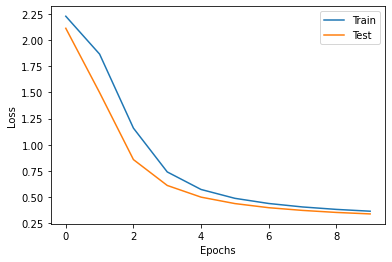

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

# Accuracy

In [20]:
correct = 0
total = 0

for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  x = x.view(-1, img_size * img_size)
  y = net(x)

  correct += (y.argmax(1) == t).sum().item()
  total += len(x)

print(f"Accuracy: {str(correct/total*100)}%")

Accuracy: 90.39%
